<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw4_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 35.88 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16678 sha256=16e5b92e2e8a6de7a6d8f93149cecdcfb3024d7082a623b0dce7eebbb91d0502
  Stored in directory: /tmp/pip-ephem-wheel-cache-hcds5zuk/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup [20pt]

In this question, we will train 3 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

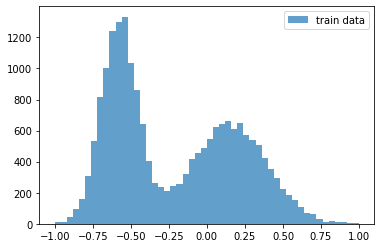

In [ ]:
visualize_q1_dataset()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader
from scipy.stats import norm
from tqdm.autonotebook import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [ ]:
class Trainer:
    def __init__(self, critic, generator, train_loader, num_epochs=10, lr=1e-2, clip_grad=1., generator_step=2, non_saturating=False):
        self.critic = critic
        self.generator = generator
        self.critic_optimizer = Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        self.generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        self.lr = lr
        self.clip_grad = clip_grad
        self.generator_step = generator_step
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.non_saturating = non_saturating

    def generator_loss(self, x):
        data_gen = self.generator.sample(x.shape[0])
        
        if self.non_saturating:
            return -torch.mean(self.critic(data_gen).log())
        
        return torch.mean((1 - self.critic(data_gen)).log())

    def critic_loss(self, x):
        data_gen = self.generator.sample(x.shape[0])
        return - torch.mean((1 - self.critic(data_gen)).log()) \
               - torch.mean(self.critic(x).log())

    def train(self):
        train_losses = [[], []]
        pbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in pbar:
            if epoch == 1:
                samples_init = self.draw_samples()
            
            epoch_losses = self.train_epoch()
            g_loss = np.mean(epoch_losses[0])
            c_loss = np.mean(epoch_losses[1])
            for i in range(2):
                train_losses[i].extend(epoch_losses[i])
            
            pbar.set_postfix_str(f'Epoch #{epoch}, c_loss: {c_loss:.4f}, g_loss: {g_loss:.4f}')

        samples_final = self.draw_samples()

        return [train_losses, *samples_init, *samples_final]

    def train_epoch(self):
        self.generator.train()
        self.critic.train()
        
        g_losses, c_losses = [], []
        for i, x in enumerate(self.train_loader):
            x = x.to(device).contiguous().float()

            c_loss = self.critic_loss(x)
            self.critic_optimizer.zero_grad()
            c_loss.backward()
            self.critic_optimizer.step()
            c_losses.append(c_loss.item())

            if not i % self.generator_step:
                g_loss = self.generator_loss(x)
                self.generator_optimizer.zero_grad()
                g_loss.backward()
                self.generator_optimizer.step()
                g_losses.append(g_loss.item())

        return g_losses, c_losses

    
    def draw_samples(self, n=5000):
        self.generator.eval()
        self.critic.eval()
        grid = np.linspace(-1, 1, 1000)
        
        samples = self.generator.sample(n)
        samples = samples.detach().cpu().numpy()
        
        critic_out = self.critic(
            torch.FloatTensor(grid).to(device).unsqueeze(1)
        )
        critic_out = critic_out.detach().cpu().numpy()
        
        return samples, grid, critic_out

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, out_size=1, num_hiddens=3, hidden_size=128):
        super().__init__()
        
        layers = []
        sizes = [input_size] + [hidden_size] * num_hiddens + [out_size]
        for inp_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(inp_size, out_size))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop(-1)
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, latent_size, data_size=1, num_hiddens=3, hidden_size=128):
        super().__init__()

        self.latent_size = latent_size
        self.mlp = MLP(latent_size, data_size, num_hiddens, hidden_size)

    def forward(self, z):
        return F.tanh(self.mlp(z))
        
    def sample(self, n):
        z = torch.normal(torch.zeros(n, self.latent_size, device=device), 
                         torch.ones(n, self.latent_size, device=device))
        return self(z)

class Critic(nn.Module):
    def __init__(self, latent_size, data_size=1, num_hiddens=3, hidden_size=128):
        super().__init__()
        self.mlp = MLP(latent_size, data_size, num_hiddens, hidden_size)
    
    def forward(self, z):
        return F.sigmoid(self.mlp(z))

In [ ]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    critic = Critic(1, 1, 3, 64).to(device)
    generator = Generator(1, 1, 3, 64).to(device)

    trainer = Trainer(critic, 
                      generator, 
                      train_loader, 
                      num_epochs=25, 
                      lr=1e-4, 
                      clip_grad=1., 
                      generator_step=2, 
                      non_saturating=False)
    train_losses, *other_out = trainer.train()

    return [train_losses[1], *other_out]

### Results

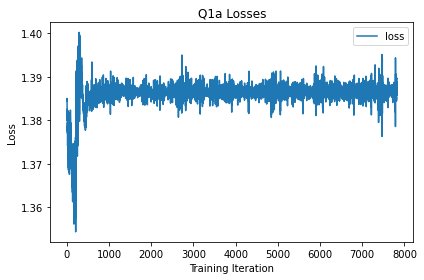

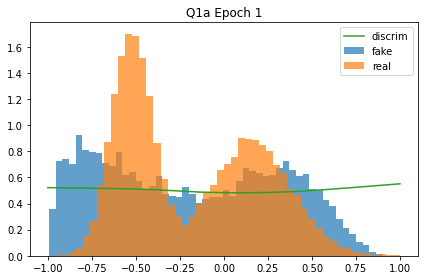

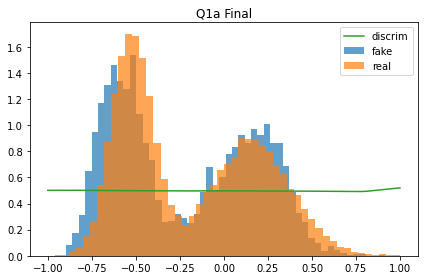

In [ ]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [ ]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    critic = Critic(1, 1, 3, 64).to(device)
    generator = Generator(1, 1, 3, 64).to(device)

    trainer = Trainer(critic, 
                      generator, 
                      train_loader, 
                      num_epochs=25, 
                      lr=1e-4, 
                      clip_grad=1., 
                      generator_step=2, 
                      non_saturating=True)
    train_losses, *other_out = trainer.train()

    return [train_losses[1], *other_out]

 ### Results

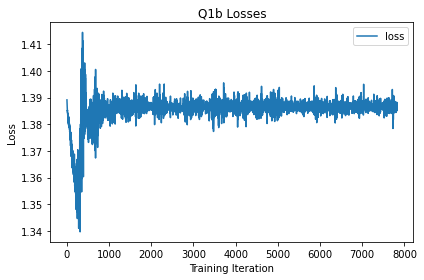

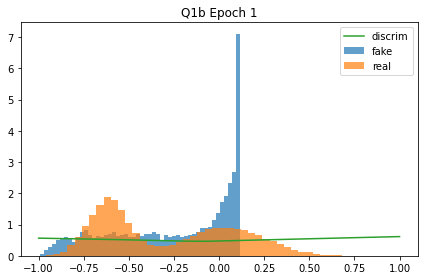

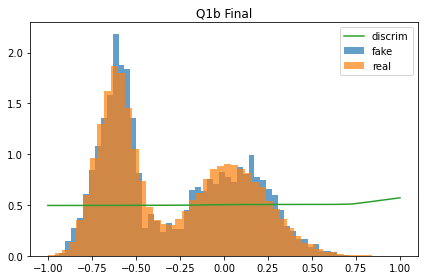

In [ ]:
q1_save_results('b', q1_b)